In [1]:
# %pip install river==0.10.1
# %pip install pmdarima
# %pip install statsforecast
# %pip install -U scikit-multiflow
# %pip install pysr


# acesso ao servidor remoto	

In [2]:
import math
import time
import numpy as np
import random
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA as statsARIMA
import pysr
from collections.abc import Iterable

In [3]:
import matplotlib.pyplot as plt

def plot(vals, labels=None, detected_anomalies=[], continuous_anomalies=[], margins=None, title='', save=False, img_name=None, show=True, divisions=[], sec_plots=[], figsize=(4,2)):
  X=range(len(vals))
  max_y, min_y = max([max(vals), *[max(sec_val) for sec_val in sec_plots]]), min([min(vals), *[min(sec_val) for sec_val in sec_plots]])
  fig, ax = plt.subplots(figsize=figsize, dpi=360)
  ax.set_title(title)
  plt.plot(vals)
  if labels:
    plt.xticks([label[0] for label in labels], [label[1] for label in labels], rotation=45)
  for subplot in sec_plots:
    plt.plot(subplot)
  for i in detected_anomalies:
    plt.scatter(i, vals[i], s=800, marker="x", color="r", alpha=0.6)
  anom_dev = max_y - min_y
  for i in continuous_anomalies:
    anom_top_margins = []
    anom_bottom_margins = []
    for point in range(i[0], i[1]):
      anom_top_margins.append(vals[point]+anom_dev)
      anom_bottom_margins.append(vals[point]-anom_dev)
    plt.fill_between(range(i[0], i[1]), anom_top_margins, anom_bottom_margins, alpha = 0.7, color="r", interpolate=True)
  plt.fill_between(
    [i for i in range(len(vals))],
    [max_y for i in range(len(vals))],
    [min_y for i in range(len(vals))],
    where=[True if i in divisions else False for i in range(len(vals))],
    color='grey', linestyle='--', alpha=0.5
  )
  j = 0
  if margins:
    for margin in margins:
      plt.fill_between(range(len(vals)), margin[0], margin[1], alpha = 0.1, color="b")
  fig.tight_layout()
  if save:
    fig.savefig(img_name if img_name is not None else title, bbox_inches='tight')
  if show:	
     plt.show()
  else:
    plt.close(fig)


Estrutura de árvore

In [4]:
class TreeNode:
  pass
class TreeNode:

  def __init__(self, content):
    self.left = None
    self.right = None
    self.cont = content

class Tree:

  def __init__(self):
    self.root = None
  
  def to_list(self):
    return Tree._sub_node_to_list(self.root)

  @staticmethod
  def _sub_node_to_list(node: TreeNode):
    if node is None:
      return []
    return [*Tree._sub_node_to_list(node.left), node.cont, *Tree._sub_node_to_list(node.right)]

  def __len__(self):
    return Tree._count_nodes(self.root)
    
  @staticmethod
  def _count_nodes(node: TreeNode):
    if node is None:
      return 0
    return 1 + Tree._count_nodes(node.left) + Tree._count_nodes(node.right)


XTSTree Base

In [5]:
from collections.abc import Iterable
from typing import Callable, Optional, Tuple, List
from pmdarima.arima import ADFTest

class XTSTree:
  
  def __init__(self, stop_condition:str='depth', stop_val=3, max_iter=1000, min_dist=50, params:dict={}):
    if stop_condition == 'depth':
      self.stop_func=self._depth_stop_condition
    elif stop_condition == 'adf':
      self.stop_func=self._adf_stop_condition
    else:
      raise ValueError(f'Stop condition {stop_condition} not supported')
    self.stop_val = stop_val
    self.max_iter = max_iter
    self.min_dist = min_dist
    self.params = params
    self.tree = Tree()
  
  def _depth_stop_condition(self, series: Iterable, depth:int):
    return (self.stop_val - 1) - depth
  
  def _adf_stop_condition(self, series: Iterable, depth=0):
    return ADFTest(self.stop_val).should_diff(series)[1]
  
  # Cria a árvore e acha os splits para uma série
  def create_splits(self, series: Iterable):
    self.tree.root = self._recursive_tree(series, params=self.params)
    return self.tree

  # Função recursiva para encontrar os nós e criar a árvore
  def _recursive_tree(self, series: Iterable, params: dict, curr_depth=0):
    if self.stop_func(series, curr_depth):
      return None
    # Achando a posição de corte e pegando os parâmetros da função de corte
    # Isso permite que a função de corte altere os parâmetros pra chamada dos próximos nós para otimizar os cortes
    cut_pos, params = self._find_cut(series=series, params=params)

    node = TreeNode(cut_pos)

    # Se achou uma posição de corte, corta a série e procura na esquerda e na direita
    if cut_pos >= 0:
      node.left = self._recursive_tree(series[:cut_pos], params=params, curr_depth=curr_depth+1)
      node.right = self._recursive_tree(series[cut_pos:], params=params, curr_depth=curr_depth+1)
      
    # Retorna o nó
    return node
    
  # Função que encontra a posição de corte, única para cada método de corte
  def _find_cut(self, series: Iterable, params: dict) -> Tuple[int, dict]:
    pass

  def apply_on_leaves(self, function, series: Iterable) -> List:
    return list(map(function, self.tree.cut_series(series)))

  def to_list(self) -> List:
    return self.tree.to_list()

  def cut_series(self, series: Iterable):
    return XTSTree._get_cuts(self.tree.root, series)
      
  def cut_points(self):
    return XTSTree._get_cut_points(self.tree.root)

  @staticmethod
  def _get_cuts(node: TreeNode, series: Iterable):
    if node is None:
      return [series]
    return [*XTSTree._get_cuts(node.left, series[:node.cont]), *XTSTree._get_cuts(node.right, series[node.cont:])]

  @staticmethod
  def _get_cut_points(node: TreeNode) -> List:
    if node is None:
      return []
    return [*XTSTree._get_cut_points(node.left), node.cont, *[cut + node.cont for cut in XTSTree._get_cut_points(node.right)]]

Separadores - XTSTree

In [6]:
from skmultiflow.drift_detection import PageHinkley

class XTSTreePageHinkley(XTSTree):
  
  def __init__(self, stop_condition: str='depth', stop_val=2, max_iter=1000, min_dist=30, min_instances: int=30, delta: float=0.005, starting_threshold: float=50.0, alpha: float=1 - 0.0001):
    self.min_instances = min_instances
    self.delta = delta
    self.threshold = starting_threshold
    self.alpha = alpha
    super().__init__(stop_condition=stop_condition, stop_val=stop_val, max_iter=max_iter, min_dist=min_dist, params={'max_threshold': -1, 'threshold': self.threshold})

  def _find_cut(self, series: Iterable, params: dict):
    # Faz uma cópia dos parâmetros porque vai retornar uma cópia dos parâmetros alterados
    # A cópia é feita dentro da função de corte porque pode não precisar alterar os parâmetros dependendo do método de corte
    params = dict(params)
    
    # Threshold mínimo sempre é 0, máximo deve começar com -1 mas idealmente é alterado para otimizar a busca
    threshold = params['threshold']
    min_threshold = 0
    max_threshold = params['max_threshold']
    # Limitando o número de iterações pra um máximo
    for n_iter in range(self.max_iter):
      # Pra reforçar a distância mínima entre cortes, o número de instâncias mínimas até detectar mudança é colocado como a distância mínima, e a série é analisada até os último min_dist elementos.
      ph = PageHinkley(min_instances=self.min_dist, delta=self.delta, threshold=threshold)
      cut_pos = []
      for i, val in enumerate(series[:-self.min_dist]):
        ph.add_element(val)
        if ph.detected_change():
          cut_pos.append(i)
          # Se detectou mais de um corte, então tem que aumentar o threshold
          if len(cut_pos) > 1:
            # Atualiza o threshold mínimo
            min_threshold = threshold
            # E faz a busca binária do threshold
            # Se for menor que 0 é porque não foi definido, então aumenta o threshold em 50%
            if max_threshold < 0:
              threshold += threshold/2
            else:
              threshold += (max_threshold - threshold)/2
            break
      n_cuts = len(cut_pos)
      if n_cuts == 1:
        # Achou apenas um corte, o threshold máximo para as próximas iterações vira o threshold atual porque thresholds maiores não vão retornar cortes nas séries cortadas
        params['max_threshold'] = threshold
        params['threshold'] = threshold/2
        return cut_pos[0], params
      elif n_cuts < 1:
        # Se não achou corte, o threshold máximo vira o atual e faz a busca binária no threshold
        max_threshold = threshold
        threshold -= (threshold-min_threshold)/2
    

    if n_cuts == 0:
      print(threshold, max_threshold)
      # Se não achou cortes, pega os cortes da threshold máxima.
      ph = PageHinkley(min_instances=self.min_dist, delta=self.delta, threshold=min_threshold)
      cut_pos = []
      for i, val in enumerate(series[:-self.min_dist]):
        ph.add_element(val)
        if ph.detected_change():
          cut_pos.append(i)
    

    # Se estourar o máximo de iterações, escolhe o ponto que gera mais estacionariedade
    print(f'Não achei um corte, pegando melhor estacionariedade {len(series)}, {threshold}, {n_cuts}')
    max_stat = -1
    final_cut = -1
    for pos in cut_pos:
      pos_stat = self.stop_func(series[:pos]) + self.stop_func(series[pos:])
      if pos_stat > max_stat:
        max_stat = pos_stat
        final_cut = pos
    params['max_threshold'] = max_threshold
    params['threshold'] = threshold
    return final_cut, params

Testes

In [7]:
from pmdarima.arima import ndiffs, nsdiffs
from statsforecast.arima import arima, AutoARIMA
from sklearn.metrics import mean_squared_error as mse

In [8]:
from warnings import simplefilter
def clear_warns():
	simplefilter("ignore", category=RuntimeWarning)
	simplefilter("ignore", category=UserWarning)

In [9]:
mse_perc=0.4
def log_aaa(series):
  preds = AutoARIMA(period=96, d=ndiffs(series, test='adf'), D=nsdiffs(series, m=96), stepwise=True).fit(series).predict_in_sample()['mean']
  err = mse(series[:int(len(series)*mse_perc)], preds[:int(len(preds)*mse_perc)])
  return list(preds), err

In [10]:
# window_size = 96
# # Multiplicador pra não deixar o desvio muito pequeno
# # No cusum os limites recomendados são 4 desvios, com a folga de meio desvio dá mais ou menos isso
# s = 3.2
# min_std = 0
# max_std = 15
# # Valor inicial caso tenha anomalia desde o começo
# std = min_std

# series_path = '/content/drive/MyDrive/IDR-PR/Dados/por estacao/23025122/export_automaticas_23025122_umidrelmed2m.csv'
# clear_warns()
# def seq_data(data, window_size=96):
#   data_X = []
#   data_Y = []
#   for i in range(len(data) - (len(data) % window_size) - window_size):
#     data_X.append(data[i:i+window_size])
#     try:
#       data_Y.append(data[i+window_size])
#     except:
#       (i+window_size)
#   return np.array(data_X), np.array(data_Y)

# from statsmodels.tsa.seasonal import seasonal_decompose

# series_len = 120 * 96

# series = pd.read_csv(series_path, nrows=series_len)['umidrelmed2m']
# # series = pd.read_csv(series_path)['umidrelmed2m']
# # series = [(math.sin(x/100)) for x in range(1000)] + [(math.sin(x/10)) for x in range(1000)]


# series = np.array([series[i] if np.isfinite(series[i]) else series[i-1] for i in range(len(series))])

# print(f'Aplicando AutoARIMA na série toda')
# t = time.perf_counter()
# pred_normal, err_normal = log_aaa(series)
# print(f'AutoARIMA aplicado em {time.perf_counter() - t} segundos')
# adf = 0.05

# print(f'ADF value {ADFTest(adf).should_diff(series)[0]}, {"não " if not ADFTest(adf).should_diff(series)[0] else ""}deve diferenciar')
# plot(series)
# print('Criando splits')


# t = time.perf_counter()
# xtstree = XTSTreePageHinkley(stop_condition='adf', stop_val=adf, min_dist=30, max_iter=100)

# xtstree.create_splits(series)
# print(f'Splits achados em {time.perf_counter() - t}: ')

# tree_predictions = xtstree.apply_on_leaves(log_aaa)

# print(f'AutoARIMA aplicado em {time.perf_counter() - t} segundos')

# tree_pred_series = []
# err_mean = 0
# for pred, err in tree_predictions:
#   tree_pred_series += pred
#   err_mean += err

# err_mean = err_mean/len(tree_predictions)

# leaves = xtstree.apply_on_leaves(len)
# cuts = [sum([leaf for leaf in leaves[:i+1]]) for i in range(len(leaves))][:-1]

# print(f'threshold do adf {adf}, erro da predição com a árvore {err_mean}, erro da predição normal {err_normal}')

# plot(series, sec_plots=[tree_pred_series], divisions=cuts, title=f'AutoARIMA com XTSTree')
# plot(pred_normal, divisions=cuts, title=f'Predições sem cortes')
# plot(tree_pred_series, divisions=cuts, title=f'Predições com cortes')


Regressão Linear - Série toda e Divisões

In [11]:
def seq_data(data, window_size=96):
  data_X = []
  data_Y = []
  for i in range(len(data) - (len(data) % window_size) - window_size):
    data_X.append(data[i:i+window_size])
    try:
      data_Y.append(data[i+window_size])
    except:
      (i+window_size)
  return np.array(data_X), np.array(data_Y)


def sr_on_series(X: pd.DataFrame, y: Iterable):
  model = pysr.PySRRegressor(
    binary_operators=['+', '-', '*', '/', 'pow'],
    unary_operators=['neg', 'exp', 'abs', 'log', 'sqrt', 'sin', 'tan', 'sinh', 'sign'],
    progress=True,
    # niterations=100,
    populations=25,
    population_size=50,
  )
  model.fit(X, y)
  return model 

ADF value 0.01, deve diferenciar


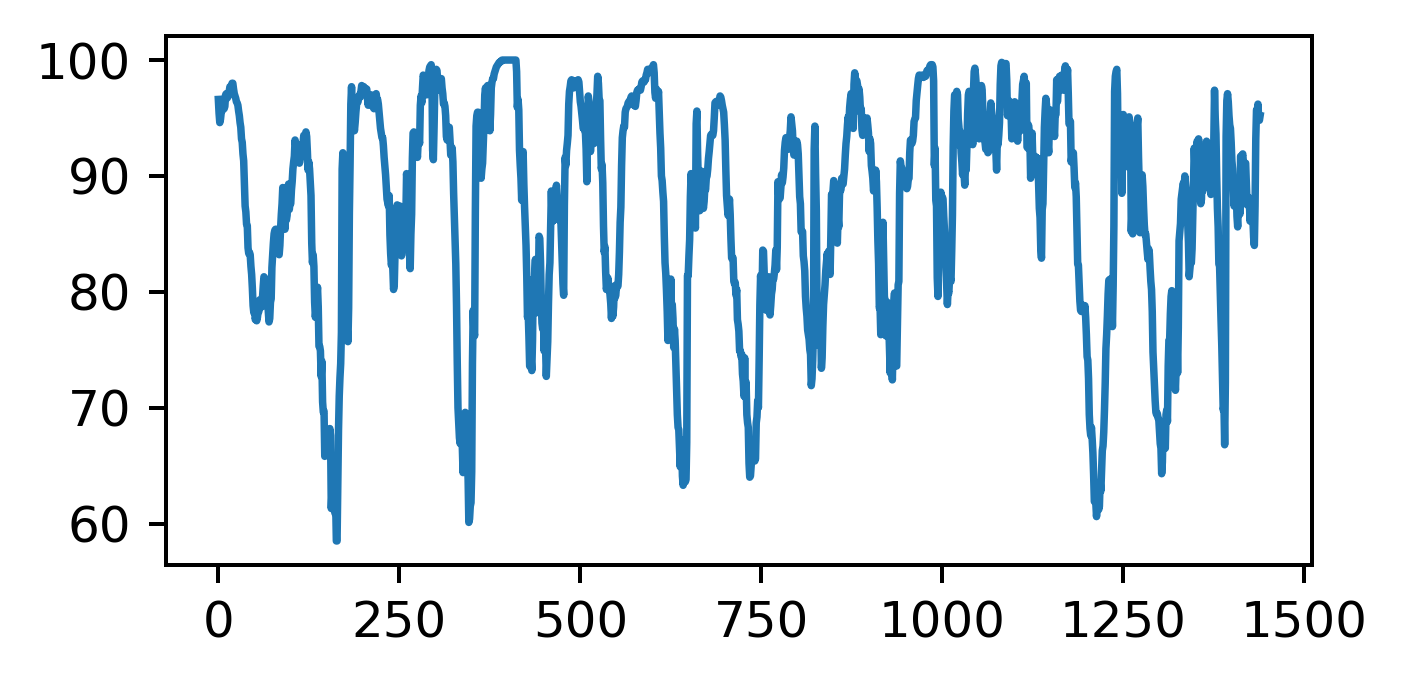

Criando splits
Não achei um corte, pegando melhor estacionariedade 1180, 1396.1224022611382, 2
Splits achados em 0.20530500000313623: 


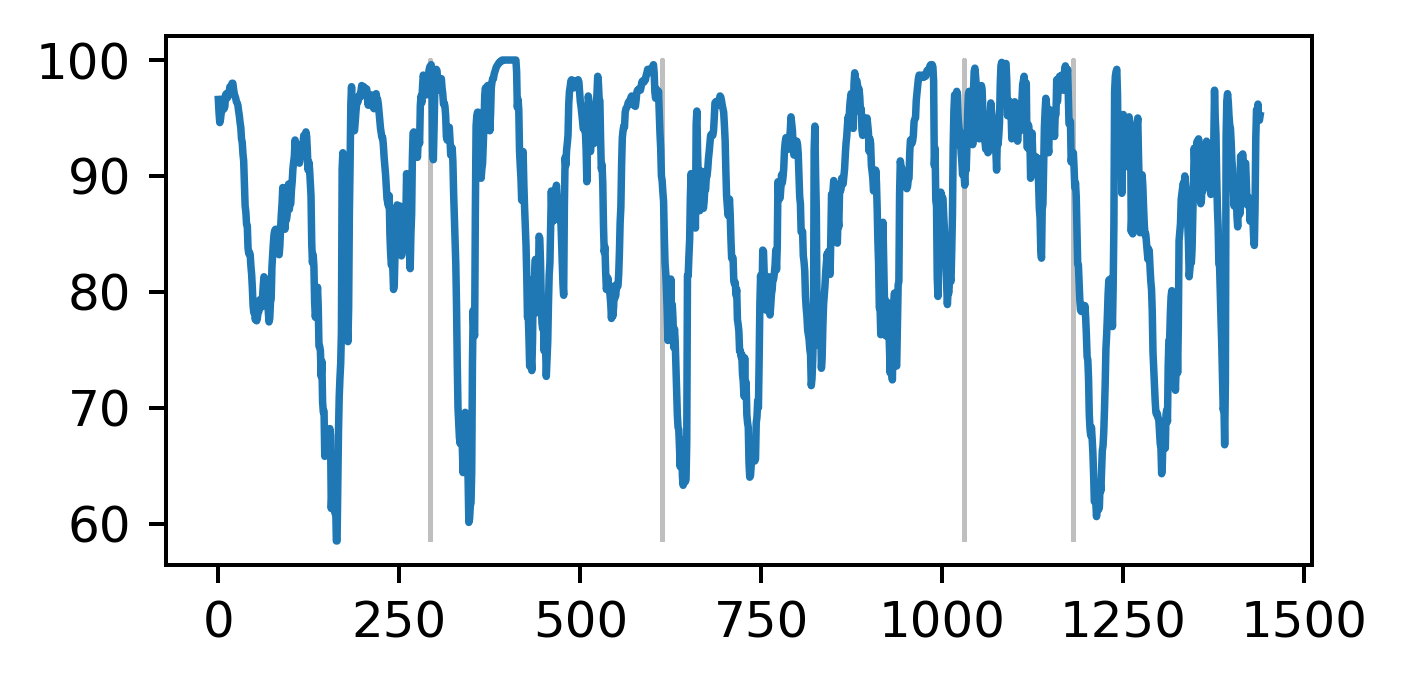

In [13]:
# series_path = '/content/drive/MyDrive/IDR-PR/Dados/por estacao/23025122/export_automaticas_23025122_umidrelmed2m.csv'
series_path = '../../../Dados/por estacao/23025122/export_automaticas_23025122_umidrelmed2m.csv'
clear_warns()

series_len = 15 * 96

series = pd.read_csv(series_path, nrows=series_len)

date_dict = {}
for i, date in enumerate(series.groupby(['date'])):
  date_dict[date[0]] = i

series['date'] = [date_dict[date] for date in series['date'].to_list()]
series['hour'] = [(int(int(h.split(':')[1])/15) + int(h.split(':')[0]) * 4) * 15 for h in series['hour'].to_list()]
series['umidrelmed2m'] = series['umidrelmed2m'].where(np.isfinite, series['umidrelmed2m'].shift(fill_value=0))


adf = 0.05

print(f'ADF value {ADFTest(adf).should_diff(series["umidrelmed2m"])[0]}, {"não " if ADFTest(adf).should_diff(series["umidrelmed2m"])[1] else ""}deve diferenciar')
plot(series['umidrelmed2m'])
print('Criando splits')

t = time.perf_counter()
xtstree = XTSTreePageHinkley(stop_condition='adf', stop_val=adf, min_dist=30, max_iter=100)
series.head()
xtstree.create_splits(series['umidrelmed2m'])
print(f'Splits achados em {time.perf_counter() - t}: ')
plot(series['umidrelmed2m'], divisions=xtstree.cut_points())

In [14]:
def log_aaa(series):
  preds = AutoARIMA(period=96, d=ndiffs(series, test='adf'), D=nsdiffs(series, m=96), stepwise=True).fit(series).predict_in_sample()['mean']
  err = mse(series[:int(len(series)*mse_perc)], preds[:int(len(preds)*mse_perc)])
  return list(preds), err

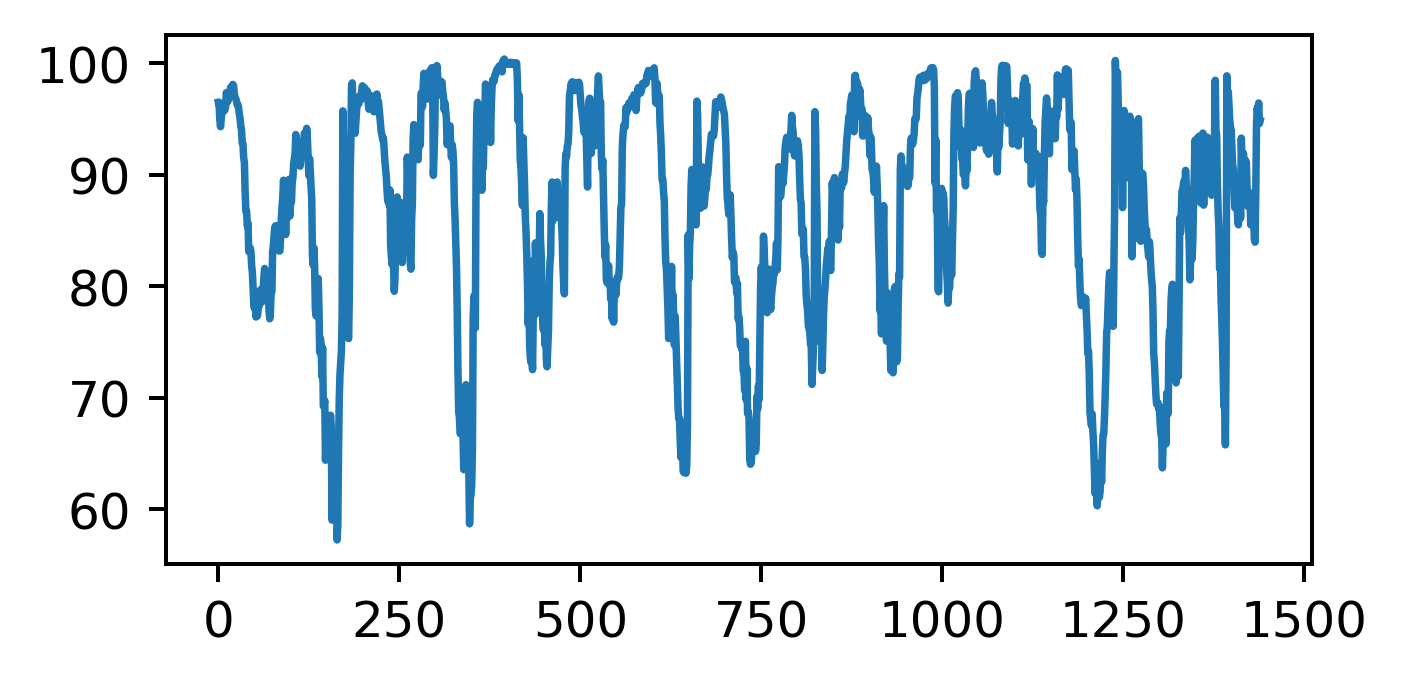

[0.5976453679515678,
 3.5121007352315226,
 4.08938589006647,
 1.6783960624619536,
 5.256022981501456]

In [23]:
pred_cuts = []
errs = []
for s in xtstree.cut_series(series['umidrelmed2m']):
  ar = log_aaa(np.array(s))
  pred_cuts = pred_cuts + ar[0]
  errs.append(ar[1])
plot(pred_cuts)
errs

In [13]:
X = series[['date', 'hour']]
y = series['umidrelmed2m']

print('SR na série toda')
t = time.perf_counter()
full_series_model = sr_on_series(X, y)
print('SR aplicado em ', time.perf_counter() - t)

print('SR nos cortes')
t = time.perf_counter()
cut_series = xtstree.cut_series(series)

cut_series_models = []

for s in cut_series:
	X = s[['date', 'hour']]
	y = s['umidrelmed2m']

	cut_series_models.append(sr_on_series(X, y))

print('SR aplicado em ', time.perf_counter() - t)

SR na série toda
SR aplicado em  614.3284813999926
SR nos cortes
SR aplicado em  1222.2011675999966


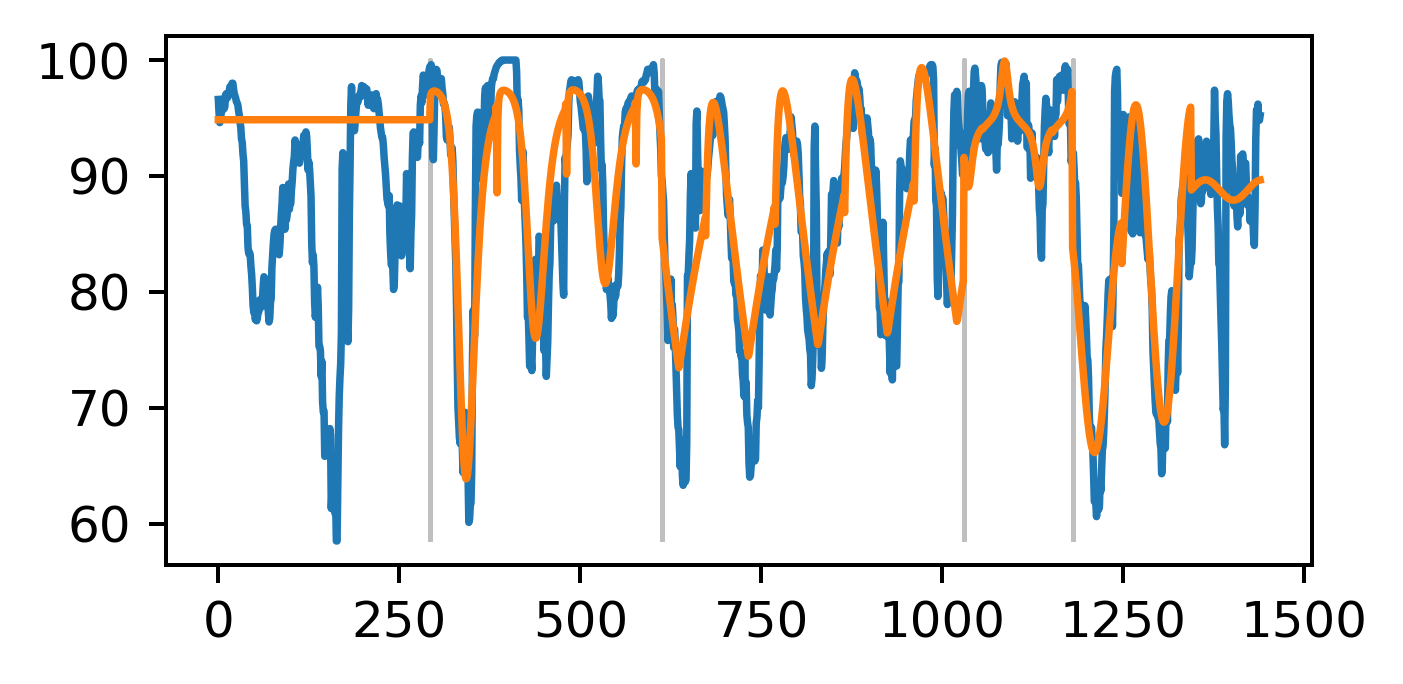

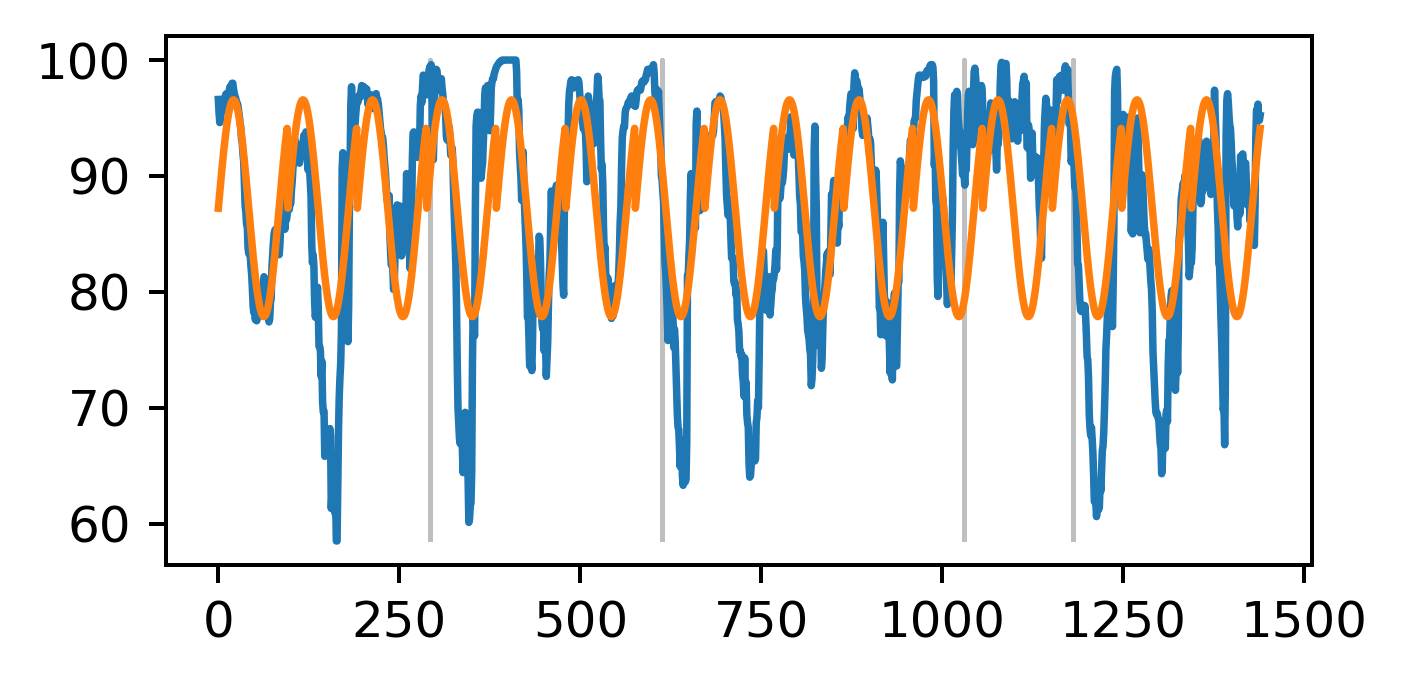

[PySRFunction(X=>exp(exp(sign(0.82210565**hour))) + 79.69395), PySRFunction(X=>97.92881 - sinh(exp(sin(hour**0.30740058) + 1.3212484/date))), PySRFunction(X=>date + Abs(hour**0.46677744*sin(log(hour + 0.0032626688)) - 11.999079) + 67.32302), PySRFunction(X=>94.482 - sinh(tan(sinh(sin(0.0043628714*1.5078441**date - 0.0043628714*hour))))), PySRFunction(X=>6.341694*date + 6.341694*sin(0.005390386*hour)/Abs(tan(date)))]


In [14]:
full_series_pred = full_series_model.predict(series[['date', 'hour']])

cut_series_pred = np.concatenate([model.predict(series) for model, series in zip(cut_series_models, cut_series)])

plot(series['umidrelmed2m'], sec_plots=[cut_series_pred], divisions=xtstree.cut_points())

plot(series['umidrelmed2m'], sec_plots=[full_series_model.predict(series[['date', 'hour']])], divisions=xtstree.cut_points())

print([model.get_best()['lambda_format'] for model in cut_series_models])
# tree_pred_series = []
# err_mean = 0
# for pred, err in tree_predictions:
#   tree_pred_series += pred
#   err_mean += err

# err_mean = err_mean/len(tree_predictions)